# Time Series Analysis

In [1]:
# import and set  necessary functionalities
import warnings
import time as t
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from multiprocessing.pool import Pool
import multiprocessing
from multiprocessing import cpu_count

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## get data into shape for time series analysis

In [2]:
!ls

2020_spring_projects.ipynb         guidelines.pdf
2020_spring_proposal_group11.pdf   man_res.png
DS_3001_Advanced_Python_Report.pdf model_results.png
bronx_decomp.png                   pred_bronx.png
bronx_res.png                      pred_brook.png
brook_res.png                      pred_ewr.png
code_var_key.rtf                   pred_man.png
ewr_res.png                        pred_queens.png
fore_bronx.png                     pred_stat.png
fore_brook.png                     queens_res.png
fore_ewr.png                       stat_res.png
fore_man.png                       timeseries_cc.ipynb
fore_queens.png                    train_dict.npy
fore_stat.png                      uber_nyc_enriched.csv


In [3]:
data = pd.read_csv('uber_nyc_enriched.csv')

In [4]:
data[:5]

,pickup_dt,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
0,2015-01-01 01:00:00,Bronx,152,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
1,2015-01-01 01:00:00,Brooklyn,1519,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2,2015-01-01 01:00:00,EWR,0,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
3,2015-01-01 01:00:00,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
4,2015-01-01 01:00:00,Queens,405,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y


In [5]:
data['pickup_dt'].min(), data['pickup_dt'].max()

('2015-01-01 01:00:00', '2015-06-30 23:00:00')

The data collects hourly data of uber pickup numbers for each of the 6 'boroughs' for 6 months. Since the same time point is repeated for each borough, we probably need to separate this data into 5 different parts, one for each borough, to conduct time series analysis on it. 

In [6]:
times = dict()

In [7]:
%load_ext line_profiler

In [8]:
def data_prep(data):
  
  data_dict = dict()
  # allocate a dictionary that stores the data for each unique borough

  for area in data['borough'].unique()[:-1]: # except NaN boroughs
    # only get the time and target variable columns
    data_dict[area] = data.loc[data['borough'] == area][['pickup_dt','pickups']]
    
    # check to see if there are any NaN values
    print(area)
    print("any NaN values?:", data_dict[area].isnull().any())
    print(50*'-')
    
  print("dataframes in my dictionary:",data_dict.keys())

  # make sure that each data frame has sorted times
  for df in data_dict.keys():
    data_dict[df] = data_dict[df].sort_values('pickup_dt')
    # make sure there are not duplicate times
    print("any duplicate times in {}?:".format(df), data_dict[df].duplicated(subset = 'pickup_dt').any())

  # convert all strings to datetime objects
  for df in data_dict.keys(): 
    data_dict[df]['pickup_dt']= pd.to_datetime(data_dict[df]['pickup_dt'])

  # set the index of each df to be the datetime column
  for df in data_dict.keys(): 
    data_dict[df] = data_dict[df].set_index('pickup_dt')

  # to make your data daily average
  # data_dict['Bronx'].resample('D').mean()

  # to make your data monthly average
  # data_dict['Bronx'].resample('MS').mean()

  # normalize each dataframe
  for df in data_dict.keys():
    scaler = MinMaxScaler() 
    data_dict[df]['pickups'] = scaler.fit_transform(data_dict[df])

  return data_dict

In [9]:
# analyze data_prepping function
import cProfile
cProfile.run('data_prep(data)')

Bronx
any NaN values?: pickup_dt    False
pickups      False
dtype: bool
--------------------------------------------------
Brooklyn
any NaN values?: pickup_dt    False
pickups      False
dtype: bool
--------------------------------------------------
EWR
any NaN values?: pickup_dt    False
pickups      False
dtype: bool
--------------------------------------------------
Manhattan
any NaN values?: pickup_dt    False
pickups      False
dtype: bool
--------------------------------------------------
Queens
any NaN values?: pickup_dt    False
pickups      False
dtype: bool
--------------------------------------------------
Staten Island
any NaN values?: pickup_dt    False
pickups      False
dtype: bool
--------------------------------------------------
dataframes in my dictionary: dict_keys(['Bronx', 'Brooklyn', 'EWR', 'Manhattan', 'Queens', 'Staten Island'])
any duplicate times in Bronx?: False
any duplicate times in Brooklyn?: False
any duplicate times in EWR?: False
any duplicate times i

       12    0.000    0.000    0.000    0.000 fromnumeric.py:2982(_ndim_dispatcher)
       12    0.000    0.000    0.000    0.000 fromnumeric.py:2986(ndim)
       12    0.000    0.000    0.000    0.000 fromnumeric.py:55(_wrapfunc)
       18    0.000    0.000    0.000    0.000 fromnumeric.py:73(_wrapreduction)
       18    0.000    0.000    0.000    0.000 fromnumeric.py:74(<dictcomp>)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:974(_argsort_dispatcher)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:978(argsort)
       24    0.000    0.000    0.000    0.000 function.py:42(__call__)
        6    0.000    0.000    0.000    0.000 function_base.py:257(iterable)
       12    0.000    0.000    0.003    0.000 generic.py:11699(logical_func)
      133    0.000    0.000    0.000    0.000 generic.py:162(__init__)
        6    0.000    0.000    0.000    0.000 generic.py:1629(_is_label_reference)
       12    0.000    0.000    0.000    0.000 generic.py:1650(<genexpr>)
 

       18    0.000    0.000    0.000    0.000 {built-in method builtins.sum}
      115    0.000    0.000    0.000    0.000 {built-in method numpy.arange}
  625/565    0.002    0.000    0.004    0.000 {built-in method numpy.array}
  150/126    0.001    0.000    0.003    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
       12    0.000    0.000    0.000    0.000 {built-in method numpy.datetime_data}
      234    0.002    0.000    0.002    0.000 {built-in method numpy.empty}
       96    0.000    0.000    0.000    0.000 {built-in method numpy.geterrobj}
       48    0.000    0.000    0.000    0.000 {built-in method numpy.seterrobj}
       18    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
       18    0.000    0.000    0.000    0.000 {built-in method pandas._libs.lib.is_datetime_array}
       43    0.000    0.000    0.000    0.000 {built-in method pandas._libs.missing.checknull}
       18    0.002    0.000    0.002    0.000 {built-in method

In [10]:
start = t.time()
data_dict = data_prep(data)
end = t.time()
print('total time spent cleaning:', end-start)
times['clean'] = end-start

Bronx
any NaN values?: pickup_dt    False
pickups      False
dtype: bool
--------------------------------------------------
Brooklyn
any NaN values?: pickup_dt    False
pickups      False
dtype: bool
--------------------------------------------------
EWR
any NaN values?: pickup_dt    False
pickups      False
dtype: bool
--------------------------------------------------
Manhattan
any NaN values?: pickup_dt    False
pickups      False
dtype: bool
--------------------------------------------------
Queens
any NaN values?: pickup_dt    False
pickups      False
dtype: bool
--------------------------------------------------
Staten Island
any NaN values?: pickup_dt    False
pickups      False
dtype: bool
--------------------------------------------------
dataframes in my dictionary: dict_keys(['Bronx', 'Brooklyn', 'EWR', 'Manhattan', 'Queens', 'Staten Island'])
any duplicate times in Bronx?: False
any duplicate times in Brooklyn?: False
any duplicate times in EWR?: False
any duplicate times i

In [11]:
# for each dataset, we will take out the last roughly 20% of the data, as test and train on the previous
# make sure the test data are multiples of whole seasons
keys_lst = list(data_dict.keys())
print(keys_lst)

train_dict = dict()
start = t.time()

for df in keys_lst:
  idx = data_dict[df].shape[0] - np.floor(np.floor(data_dict[df].shape[0]*0.2) / 24) * 24
  print('grabbed the first {} entries of the {} data'.format(idx, df))
  train_dict[df] = data_dict[df][:3479]

end = t.time()
print('total time spent splitting data', end-start)
times['split'] = end-start

['Bronx', 'Brooklyn', 'EWR', 'Manhattan', 'Queens', 'Staten Island']
grabbed the first 3479.0 entries of the Bronx data
grabbed the first 3479.0 entries of the Brooklyn data
grabbed the first 3479.0 entries of the EWR data
grabbed the first 3479.0 entries of the Manhattan data
grabbed the first 3479.0 entries of the Queens data
grabbed the first 3479.0 entries of the Staten Island data
total time spent splitting data 0.003960132598876953


In [12]:
# save this dictionary as a file for later import
np.save('train_dict.npy', train_dict) 
# train_dict = np.load('train_dict.npy',allow_pickle='TRUE').item()

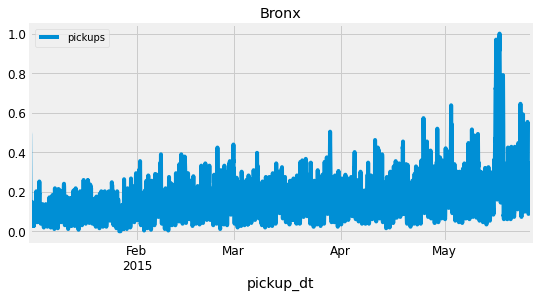

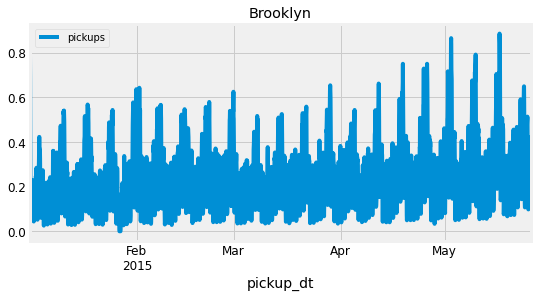

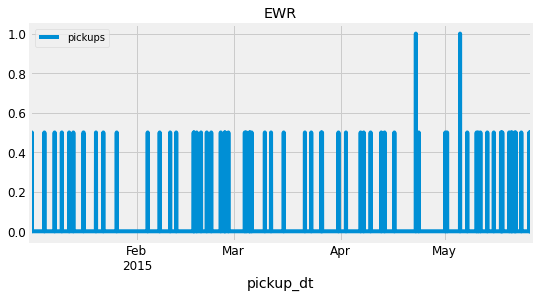

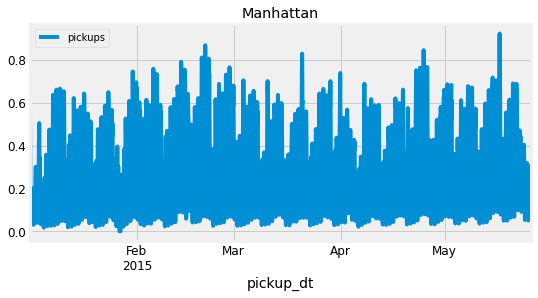

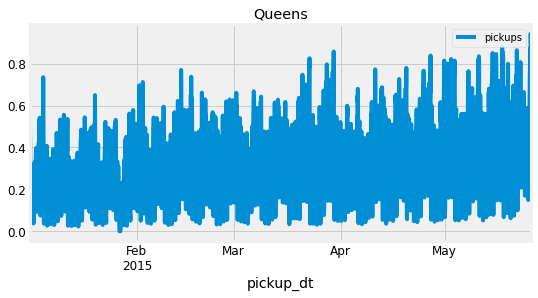

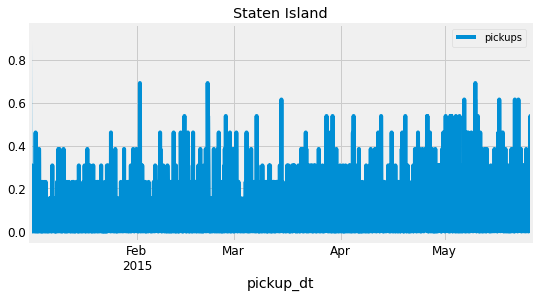

In [13]:
for df in train_dict.keys():  
  train_dict[df].plot(figsize=(8,4))
  plt.title(df)
  plt.show()

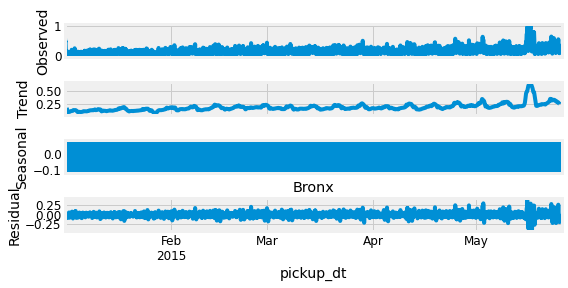

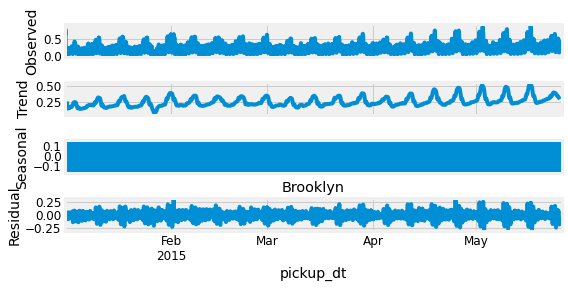

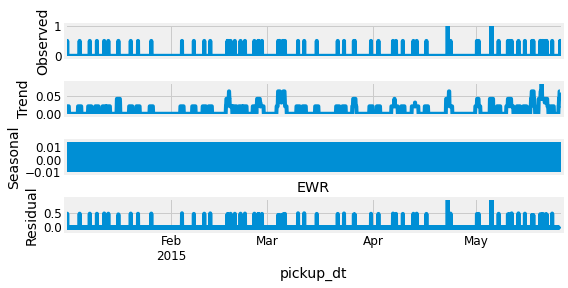

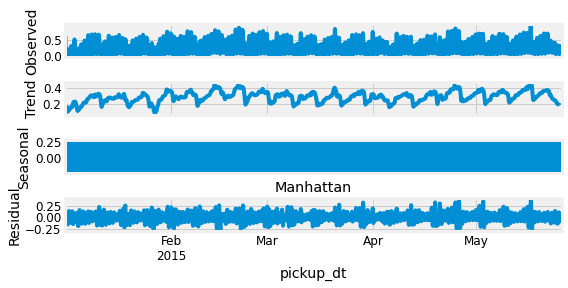

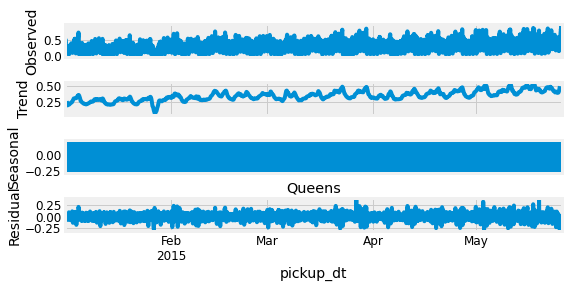

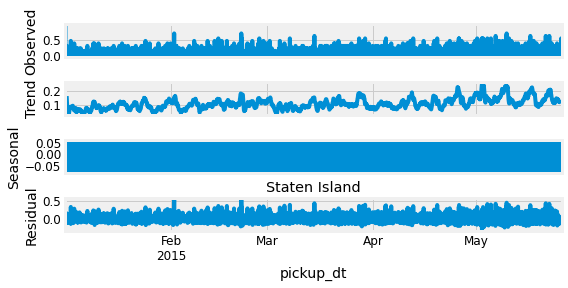



total time spent on decomposition: 9.34074091911316


In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 4

# plot time series decomposition for each borough
def plot_decomp(train_dict):
  for df in train_dict.keys():
    decomposition = sm.tsa.seasonal_decompose(train_dict[df], model='additive')
    fig = decomposition.plot()
    plt.title(df)
    plt.show()
    print()
    print()

start = t.time()
plot_decomp(train_dict)
end = t.time()
print('total time spent on decomposition:', end-start)
times['decomp'] = end-start

In [0]:
# plot time series decomposition for each borough
def plot_decomp_multi(ts_df):
  decomposition = sm.tsa.seasonal_decompose(ts_df, model='additive')
  fig = decomposition.plot()
  plt.show()
  print()
  print()

if __name__ == '__main__':
  num_proc = multiprocessing.cpu_count()
  p = multiprocessing.Pool(num_proc)
  p.map(plot_decomp_multi,[train_dict[df] for df in train_dict.keys()])

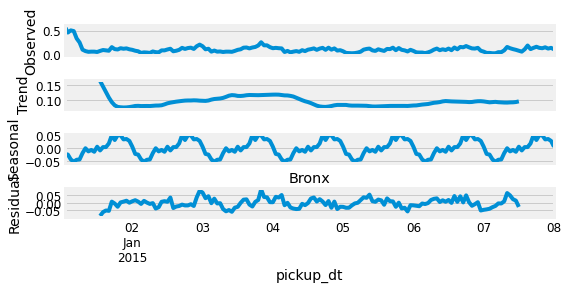

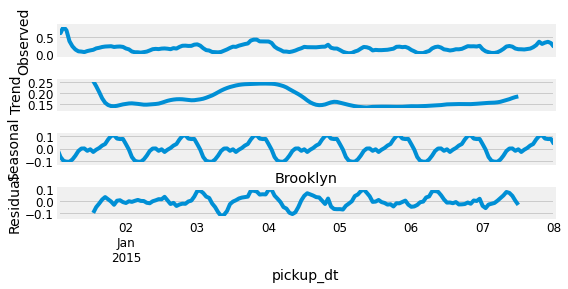

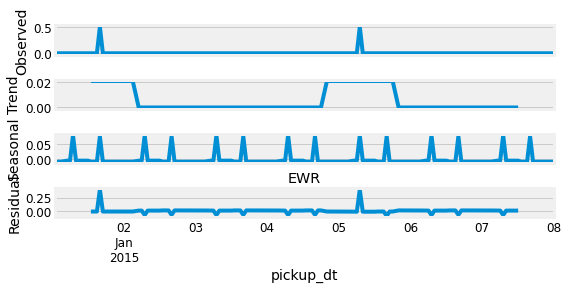

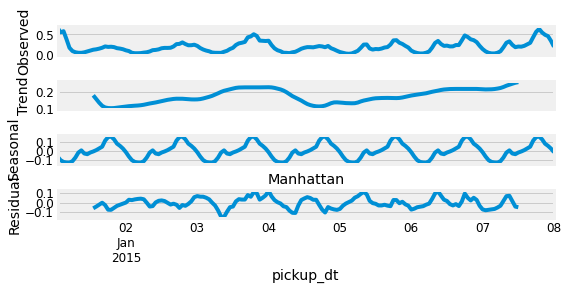

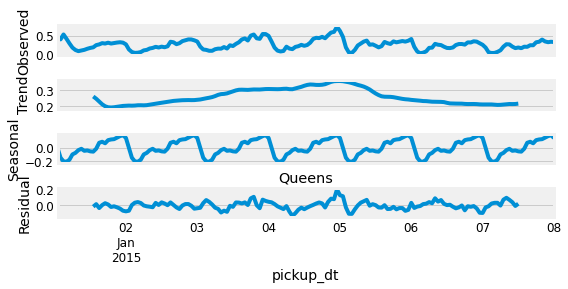

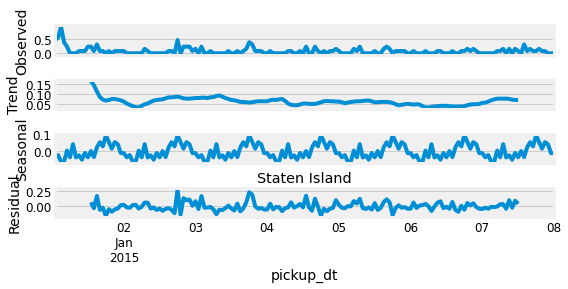

In [15]:
# lets just plot the decomp again on a smaller scale to observe seasonality and periodicity
# remember, this is hourly data
# plot time series decomposition for each borough
# let us just observe the data in 7 days
for df in train_dict.keys():
  decomposition = sm.tsa.seasonal_decompose(train_dict[df][:168], model='additive') 
  fig = decomposition.plot()
  plt.title(df)
  plt.show()
  print()
  print()

The seasonality is apparent on a per-day scale, that is, every 24 data entires (24 hrs for hourly data) we observe some repetition in data behavior. Thus, our seasonal frequency aka periodicity would be 24.

## ARIMA model

In [22]:
# for-loop to get parameter grid
start = t.time()
pdq = []
for p in range(2):
  for d in range(2):
    for q in range(2):
      pdq.append((p,d,q))

seasonal_pdq = []
for x in pdq:
  seasonal_pdq.append((x[0], x[1], x[2], 24))

grid = []
for i in pdq:
  for j in seasonal_pdq:
    grid.append((i,j))

end = t.time()
print('the total time to get search grid:', end - start)
times['get_grid_for'] = end-start

the total time to get search grid: 0.0002818107604980469


In [28]:
# use itertools to get parameter grid
start = t.time()

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

grid = list(itertools.product(pdq, seasonal_pdq))

end = t.time()
print('the total time to get search grid:', end - start)
times['get_grid_iter'] = end-start

the total time to get search grid: 0.00024199485778808594


In [29]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
print('A few examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
print("the total number of parameter combinations to try:",len(list(itertools.product(pdq, seasonal_pdq))))

A few examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 1, 0, 24)
SARIMAX: (0, 1, 0) x (0, 1, 1, 24)
SARIMAX: (0, 1, 0) x (1, 0, 0, 24)
the total number of parameter combinations to try: 64


In [30]:
def find_param(ts_df, pdq, seasonal_pdq):
  '''
  ts_df: a time series dataframe with datetime objects as index and value as the only other column
  pdq: a list of different order parameter values (these values are tuples)
  seasonal_pdq: a list of different seasonal_order parameter values (these values are tuples)
  '''
  minAIC = 10**8

  ts_df.index = pd.DatetimeIndex(ts_df.index.values,
                                 freq=ts_df.index.inferred_freq) # set frequency to avoid warning
  for param in pdq:
    for param_seasonal in seasonal_pdq:
      try:

        mod = sm.tsa.statespace.SARIMAX(ts_df,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        if results.aic < minAIC: # keep track of the best params
          best_params = {'order': param, 'seasonal_order': param_seasonal, 'minAIC': results.aic}
          minAIC = results.aic
      except:
          continue

  print('the best parameters are: ARIMA{}x{} - AIC:{}'.format(best_params['order'], 
                                                              best_params['seasonal_order'], 
                                                              best_params['minAIC']))  

  return best_params

In [0]:
best_params_dict = dict()

start = t.time()

for df in train_dict.keys():
  best_params_dict[df] = find_param(train_dict[df], pdq, seasonal_pdq)

end = t.time()
print("total time spent on grid search:", end - start)
times['grid_search'] = end-start

the best parameters are: ARIMA(1, 0, 1)x(1, 0, 1, 24) - AIC:-11749.16332826469
the best parameters are: ARIMA(1, 0, 1)x(1, 1, 1, 24) - AIC:-13940.69232958924
the best parameters are: ARIMA(1, 0, 1)x(0, 0, 0, 24) - AIC:-8304.604605601418
the best parameters are: ARIMA(1, 0, 1)x(1, 1, 1, 24) - AIC:-13171.74264575796
the best parameters are: ARIMA(1, 0, 1)x(1, 0, 1, 24) - AIC:-10321.197330620835
the best parameters are: ARIMA(1, 0, 1)x(1, 0, 1, 24) - AIC:-5859.308267172053
total time spent on grid search: 3452.0252158641815


In [47]:
best_params_dict

{'Bronx': {'order': (1, 0, 1),
  'seasonal_order': (1, 0, 1, 24),
  'minAIC': -11749.16332826469},
 'Brooklyn': {'order': (1, 0, 1),
  'seasonal_order': (1, 1, 1, 24),
  'minAIC': -13940.69232958924},
 'EWR': {'order': (1, 0, 1),
  'seasonal_order': (0, 0, 0, 24),
  'minAIC': -8304.604605601418},
 'Manhattan': {'order': (1, 0, 1),
  'seasonal_order': (1, 1, 1, 24),
  'minAIC': -13171.74264575796},
 'Queens': {'order': (1, 0, 1),
  'seasonal_order': (1, 0, 1, 24),
  'minAIC': -10321.197330620835},
 'Staten Island': {'order': (1, 0, 1),
  'seasonal_order': (1, 0, 1, 24),
  'minAIC': -5859.308267172053}}

In [31]:
pairs_with_df = itertools.product([train_dict['Bronx']], pdq, seasonal_pdq)
print(len(list(pairs_with_df)))

64


In [32]:
def get_chunks(iterable, chunks=1):
    # This is from http://stackoverflow.com/a/2136090/2073595
    lst = list(iterable)
    return [lst[i::chunks] for i in range(chunks)]

def find_param_multi(pairs_with_df):
  '''
  pairs_with_df: a list containing tuples where each tuple has
    ts_df: a time series dataframe with datetime objects as index and value as the only other column
    param: 1 input for the  order parameter values
    param_seasonal: 1 input for seasonal_order parameter values
  '''
  minAIC = 10**8
  for ts_df, param, param_seasonal in pairs_with_df:
    try:
      ts_df.index = pd.DatetimeIndex(ts_df.index.values,
                               freq=ts_df.index.inferred_freq) # set frequency to avoid warning
      
      mod = sm.tsa.statespace.SARIMAX(ts_df,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
      results = mod.fit()
      if results.aic < minAIC: # keep track of the best params
        best_order = param
        best_seasonal_order = param_seasonal
        minAIC = results.aic
    except:
        continue

  # print('the best parameters are: ARIMA{}x{} with AIC:{}'.format(best_order, best_seasonal_order, minAIC))  

  return minAIC, best_order, best_seasonal_order



In [35]:
keys

['Bronx', 'Brooklyn', 'EWR', 'Manhattan', 'Queens', 'Staten Island']

In [33]:
best_params_dict = dict()

keys = list(train_dict.keys())

start = t.time()
print(keys[0])
pairs_with_df = itertools.product([train_dict[keys[0]]], pdq, seasonal_pdq)
chunked_pairs =  get_chunks(pairs_with_df, chunks=multiprocessing.cpu_count())
with Pool() as p:
  results = p.map(find_param_multi, chunked_pairs)

sorted_results = sorted(results, key=lambda x: x[0])
best = sorted_results[0]
best_params_dict[keys[0]] = {'order': best[1], 'seasonal_order': best[2], 'minAIC': best[0]}

end = t.time()
print("total time spent on grid search for {}:".format(keys[0]), end - start)
times['grid_search_Bronx'] = end-start

Bronx


/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


total time spent on grid search for Bronx: 463.1313111782074


In [36]:
start = t.time()
print(keys[1])
pairs_with_df = itertools.product([train_dict[keys[1]]], pdq, seasonal_pdq)
chunked_pairs =  get_chunks(pairs_with_df, chunks=multiprocessing.cpu_count())
with Pool() as p:
  results = p.map(find_param_multi, chunked_pairs)

sorted_results = sorted(results, key=lambda x: x[0])
best = sorted_results[0]
best_params_dict[keys[1]] = {'order': best[1], 'seasonal_order': best[2], 'minAIC': best[0]}

end = t.time()
print("total time spent on grid search for {}:".format(keys[1]), end - start)
times['grid_search_Brooklyn'] = end-start

Brooklyn


/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


total time spent on grid search for Brooklyn: 479.99218702316284


In [37]:
start = t.time()
print(keys[2])
pairs_with_df = itertools.product([train_dict[keys[2]]], pdq, seasonal_pdq)
chunked_pairs =  get_chunks(pairs_with_df, chunks=multiprocessing.cpu_count())
with Pool() as p:
  results = p.map(find_param_multi, chunked_pairs)

sorted_results = sorted(results, key=lambda x: x[0])
best = sorted_results[0]
best_params_dict[keys[2]] = {'order': best[1], 'seasonal_order': best[2], 'minAIC': best[0]}

end = t.time()
print("total time spent on grid search for {}:".format(keys[2]), end - start)
times['grid_search_ewr'] = end-start

EWR


/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum 

total time spent on grid search for EWR: 553.8163018226624


In [38]:
start = t.time()
print(keys[3])
pairs_with_df = itertools.product([train_dict[keys[3]]], pdq, seasonal_pdq)
chunked_pairs =  get_chunks(pairs_with_df, chunks=multiprocessing.cpu_count())
with Pool() as p:
  results = p.map(find_param_multi, chunked_pairs)

sorted_results = sorted(results, key=lambda x: x[0])
best = sorted_results[0]
best_params_dict[keys[3]] = {'order': best[1], 'seasonal_order': best[2], 'minAIC': best[0]}

end = t.time()
print("total time spent on grid search for {}:".format(keys[3]), end - start)
times['grid_search_man'] = end-start

Manhattan


/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


total time spent on grid search for Manhattan: 427.1262867450714


In [39]:
start = t.time()
print(keys[4])
pairs_with_df = itertools.product([train_dict[keys[4]]], pdq, seasonal_pdq)
chunked_pairs =  get_chunks(pairs_with_df, chunks=multiprocessing.cpu_count())
with Pool() as p:
  results = p.map(find_param_multi, chunked_pairs)

sorted_results = sorted(results, key=lambda x: x[0])
best = sorted_results[0]
best_params_dict[keys[4]] = {'order': best[1], 'seasonal_order': best[2], 'minAIC': best[0]}

end = t.time()
print("total time spent on grid search for {}:".format(keys[4]), end - start)
times['grid_search_queens'] = end-start

Queens


/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


total time spent on grid search for Queens: 462.1843090057373


In [40]:
start = t.time()
print(keys[5])
pairs_with_df = itertools.product([train_dict[keys[5]]], pdq, seasonal_pdq)
chunked_pairs =  get_chunks(pairs_with_df, chunks=multiprocessing.cpu_count())
with Pool() as p:
  results = p.map(find_param_multi, chunked_pairs)

sorted_results = sorted(results, key=lambda x: x[0])
best = sorted_results[0]
best_params_dict[keys[5]] = {'order': best[1], 'seasonal_order': best[2], 'minAIC': best[0]}

end = t.time()
print("total time spent on grid search for {}:".format(keys[5]), end - start)
times['grid_search_stat'] = end-start

Staten Island


/Users/w849277/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


total time spent on grid search for Staten Island: 532.4880220890045


In [43]:
times['grid_search_opt'] = times['grid_search_Bronx'] + times['grid_search_Brooklyn'] + times['grid_search_ewr'] + times['grid_search_man'] + times['grid_search_queens'] + times['grid_search_stat']
print('the total optimized grid search time:', times['grid_search_opt'])

the total optimized grid search time: 2918.738417863846


In [44]:
best_params_dict

{'Bronx': {'order': (1, 0, 1),
  'seasonal_order': (1, 0, 1, 24),
  'minAIC': -11749.16332826469},
 'Brooklyn': {'order': (1, 0, 1),
  'seasonal_order': (1, 1, 1, 24),
  'minAIC': -13940.69232958924},
 'EWR': {'order': (1, 0, 1),
  'seasonal_order': (0, 0, 0, 24),
  'minAIC': -8304.604605601418},
 'Manhattan': {'order': (1, 0, 1),
  'seasonal_order': (1, 1, 1, 24),
  'minAIC': -13171.74264575796},
 'Queens': {'order': (1, 0, 1),
  'seasonal_order': (1, 0, 1, 24),
  'minAIC': -10321.197330620835},
 'Staten Island': {'order': (1, 0, 1),
  'seasonal_order': (1, 0, 1, 24),
  'minAIC': -5859.308267172053}}

In [0]:
# fit using the best parameters
def final_fit(ts_df, best_params):
  '''
  ts_df: a time series dataframe
  best_params: a dictionary with 3 key-value pairs, 'order', 'seasonal_order', and 'minAIC'
  '''
  mod = sm.tsa.statespace.SARIMAX(ts_df,
                                  order=best_params['order'],
                                  seasonal_order=best_params['seasonal_order'],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
  results = mod.fit()
  print(results.summary().tables[1])

  return results

In [49]:
start = t.time()

result_dict=dict()
for df in train_dict.keys():
  print(df)
  result_dict[df] = final_fit(train_dict[df], best_params_dict[df])

end = t.time()
print('the total time spent fitting the best model is:', end-start)
times['fit'] = end - start

Bronx
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8615      0.006    147.832      0.000       0.850       0.873
ma.L1         -0.0529      0.014     -3.787      0.000      -0.080      -0.025
ar.S.L24       1.0058      0.001   1554.933      0.000       1.005       1.007
ma.S.L24      -0.9711      0.005   -198.966      0.000      -0.981      -0.962
sigma2         0.0019   3.11e-05     61.286      0.000       0.002       0.002
Brooklyn
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9049      0.005    175.222      0.000       0.895       0.915
ma.L1          0.3532      0.013     27.387      0.000       0.328       0.379
ar.S.L24       0.1565      0.015     10.603      0.000       0.128       0.185
ma.S.L24      -0.9731      0.005   -1

In [50]:
result_dict

{'Bronx': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1c2778e990>,
 'Brooklyn': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1c272fb990>,
 'EWR': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1c27a99a10>,
 'Manhattan': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1c256e60d0>,
 'Queens': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1c277fdc10>,
 'Staten Island': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1c27775ed0>}

Bronx


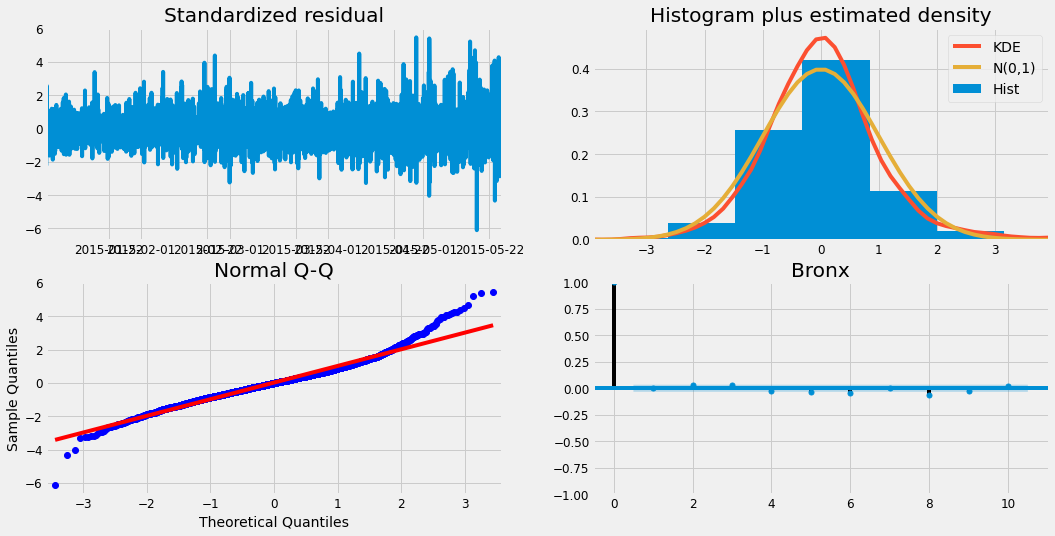

Brooklyn


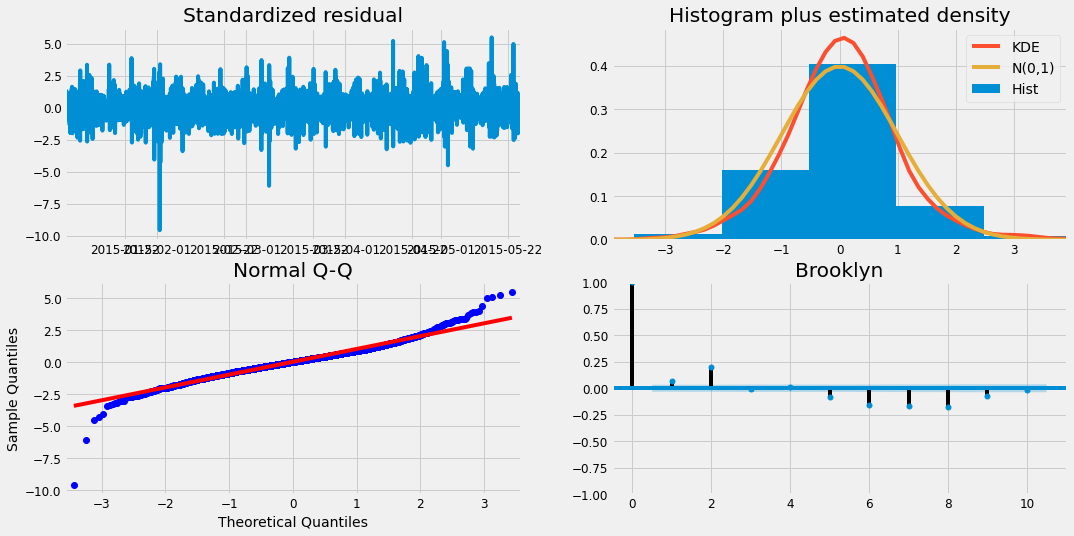

EWR


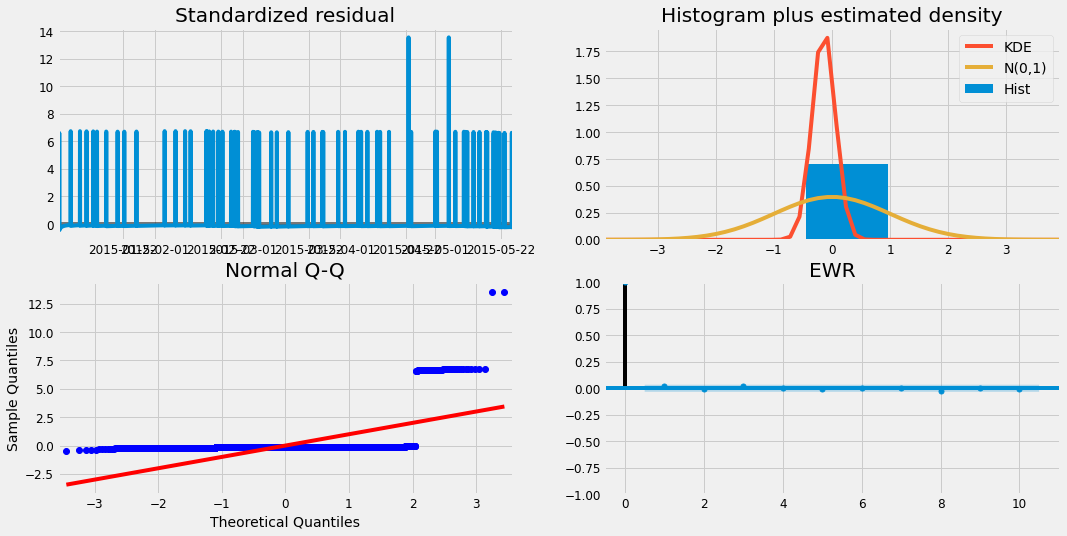

Manhattan


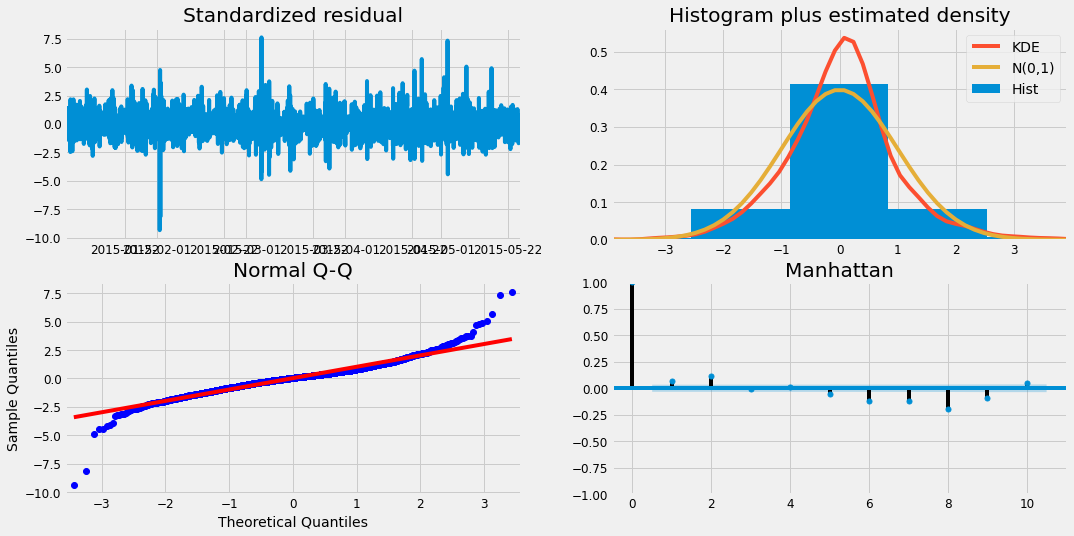

Queens


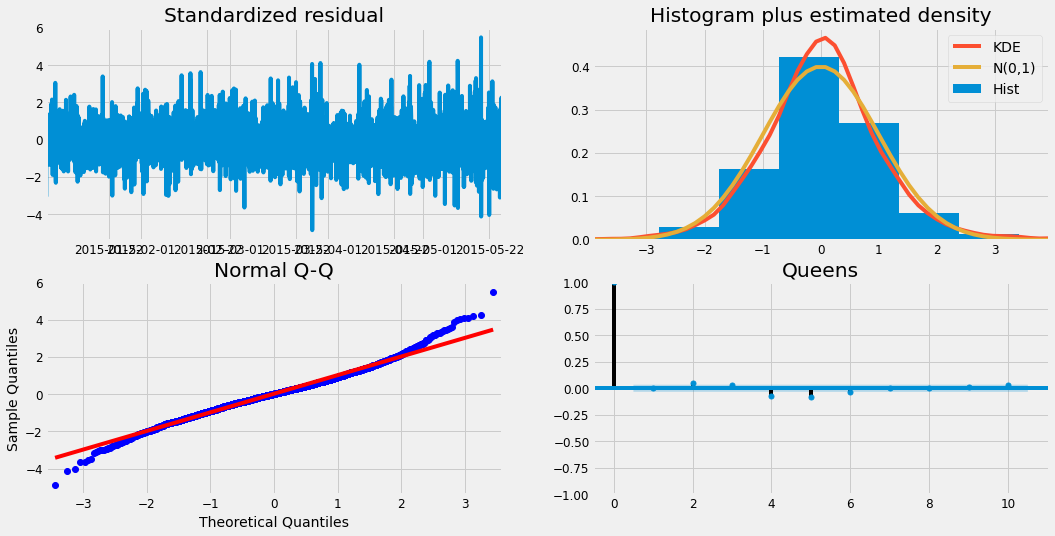

Staten Island


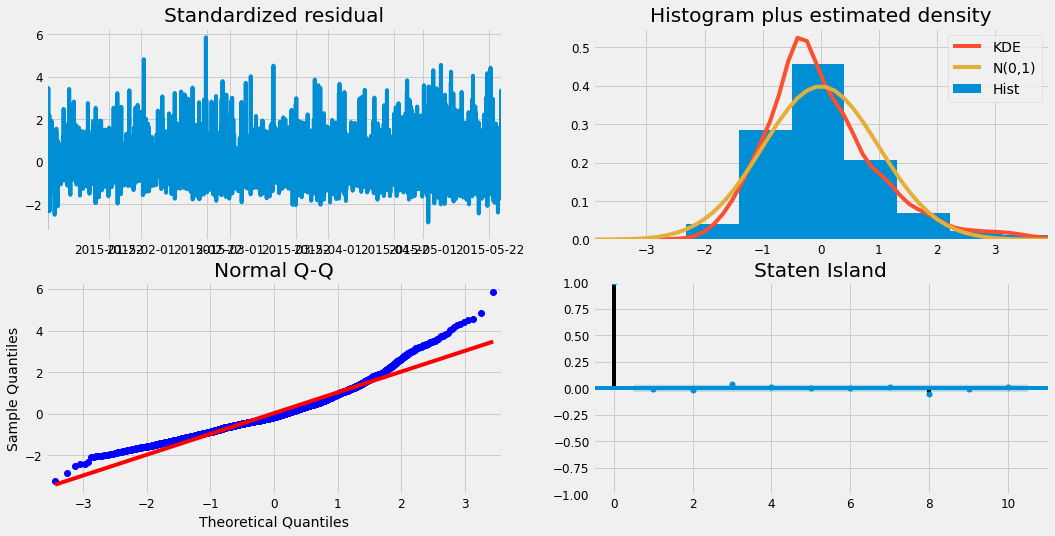

In [54]:
# analyze the residuals
for model in result_dict.keys():
  print(model)
  result_dict[model].plot_diagnostics(figsize=(16, 8))
  plt.title(model)
  plt.show()

In [55]:
train_dict['Bronx'][:1],train_dict['Bronx'][-1:]

(                      pickups
 pickup_dt                    
 2015-01-01 01:00:00  0.580153,                      pickups
 pickup_dt                   
 2015-05-25 23:00:00  0.29771)

In [56]:
data_dict['Bronx'][:1] ,data_dict['Bronx'][-1:]

(                      pickups
 pickup_dt                    
 2015-01-01 01:00:00  0.580153,                       pickups
 pickup_dt                    
 2015-06-30 23:00:00  0.255725)

our forcast is hourly from 2015-05-26 00:00:00 to 2015-06-30 23:00:00, 864 hourly entries

In [0]:
# compare in-sample predicted pickups to true pickups
def check_pred(results, ts_df):
  '''
  results: fitted ARIMA model
  ts_df: corresponding training time series dataframe
  '''
  pred = results.get_prediction(start=pd.to_datetime('2015-05-10 00:00:00'),
                                dynamic=False)
  pred_ci = pred.conf_int()
  ax = ts_df['2015-04-10 1:00:00':].plot(label='observed')
  pred.predicted_mean.plot(ax=ax, label='15 day In-sample prediction', alpha=.7, figsize=(8, 4))
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.2)
  ax.set_xlabel('time')
  ax.set_ylabel('pickups')
  plt.legend()
  plt.show()

  # get prediction error
  y_predicted = pd.DataFrame(pred.predicted_mean)
  y_truth = ts_df['2015-05-10 00:00:00':]
  mse = ((y_predicted[0] - y_truth['pickups']) ** 2).mean()
  print('The Mean Squared Error of our prediction is {}'.format(round(mse, 2)))
  print('The Root Mean Squared Error of our prediction is {}'.format(round(np.sqrt(mse), 2)))
  return mse, np.sqrt(mse)

For Bronx


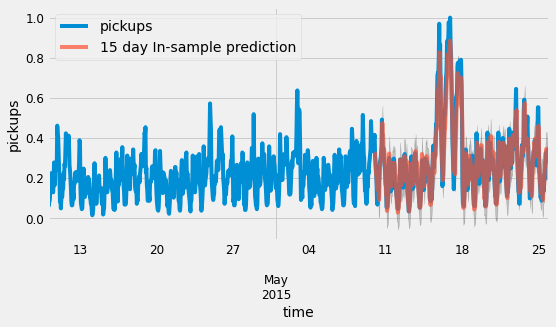

The Mean Squared Error of our prediction is 0.0
The Root Mean Squared Error of our prediction is 0.06
--------------------------------------------------
For Brooklyn


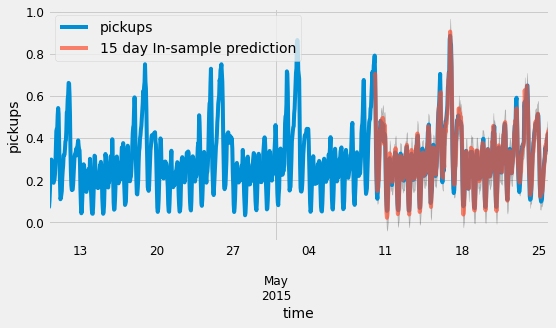

The Mean Squared Error of our prediction is 0.0
The Root Mean Squared Error of our prediction is 0.03
--------------------------------------------------
For EWR


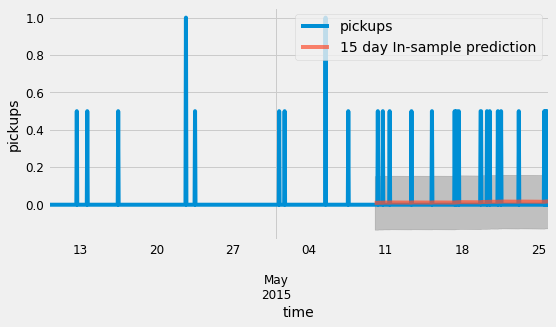

The Mean Squared Error of our prediction is 0.01
The Root Mean Squared Error of our prediction is 0.11
--------------------------------------------------
For Manhattan


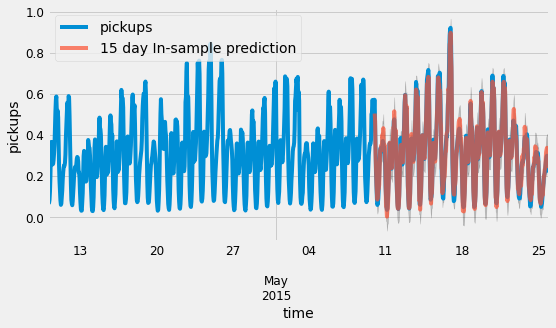

The Mean Squared Error of our prediction is 0.0
The Root Mean Squared Error of our prediction is 0.03
--------------------------------------------------
For Queens


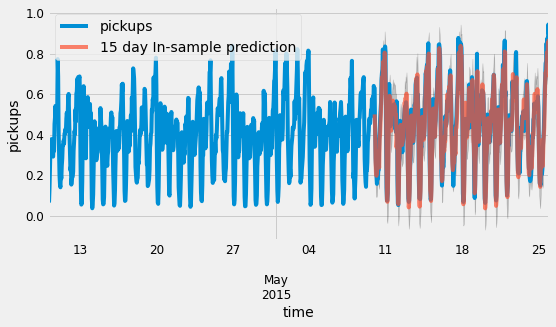

The Mean Squared Error of our prediction is 0.0
The Root Mean Squared Error of our prediction is 0.07
--------------------------------------------------
For Staten Island


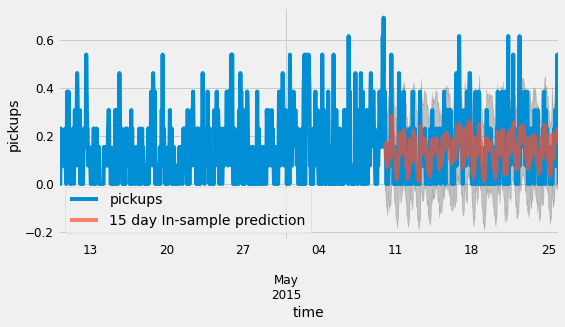

The Mean Squared Error of our prediction is 0.01
The Root Mean Squared Error of our prediction is 0.11
--------------------------------------------------
the average in-sample-prediction MSE across all boroughs: 0.005767904288009142
the average in-sample-prediction RMSE across all boroughs: 0.06902680743226586
the total time for in-sample prediction is 2.5249717235565186


In [60]:
start = t.time()
pred_mse = []
pred_rmse = []
for df in result_dict.keys():
  print('For', df)
  mse, rmse = check_pred(result_dict[df], train_dict[df])
  pred_mse.append(mse)
  pred_rmse.append(rmse)
  print(50*'-')

print('the average in-sample-prediction MSE across all boroughs:', np.mean(pred_mse))
print('the average in-sample-prediction RMSE across all boroughs:', np.mean(pred_rmse))

end = t.time()
print('the total time for in-sample prediction is', end-start)
times['predict'] = end-start

In [0]:
# compare out-of-sample forecasts to true values
def check_forecast(results, ts_df):
  '''
  results: fitted ARIMA model
  ts_df: corresponding original time series dataframe
  '''
  pred_uc = results.get_forecast(steps=pd.to_datetime('2015-06-30 23:00:00'))
  pred_ci = pred_uc.conf_int()
  ax = ts_df['2015-05-01 1:00:00':].plot(label='observed', figsize=(8, 4))
  pred_uc.predicted_mean.plot(ax=ax, label='36 day out-of-sample forecast')
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.25)
  ax.set_xlabel('Date')
  ax.set_ylabel('pickups')
  plt.legend()
  plt.show()

  # get forecast error
  y_predicted = pd.DataFrame(pred_uc.predicted_mean)
  y_truth = data_dict['Bronx']['2015-05-26 00:00:00':]
  mse = ((y_predicted[0] - y_truth['pickups']) ** 2).mean()
  print('The Mean Squared Error of our prediction is {}'.format(round(mse, 2)))
  print('The Root Mean Squared Error of our prediction is {}'.format(round(np.sqrt(mse), 2)))

  return mse, np.sqrt(mse)

For Bronx


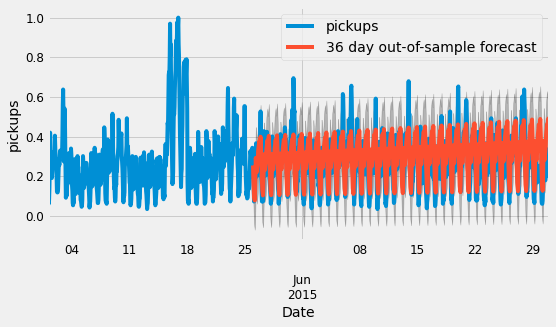

The Mean Squared Error of our prediction is 0.01
The Root Mean Squared Error of our prediction is 0.1
--------------------------------------------------
For Brooklyn


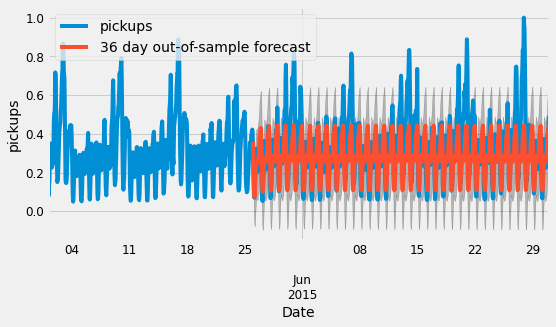

The Mean Squared Error of our prediction is 0.01
The Root Mean Squared Error of our prediction is 0.1
--------------------------------------------------
For EWR


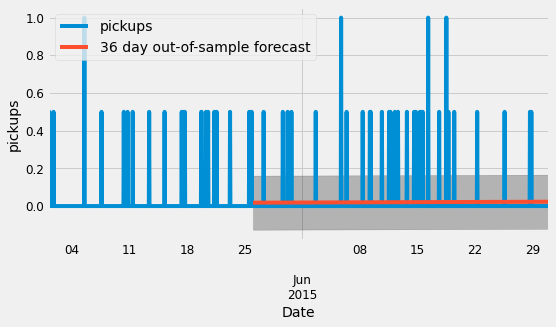

The Mean Squared Error of our prediction is 0.07
The Root Mean Squared Error of our prediction is 0.27
--------------------------------------------------
For Manhattan


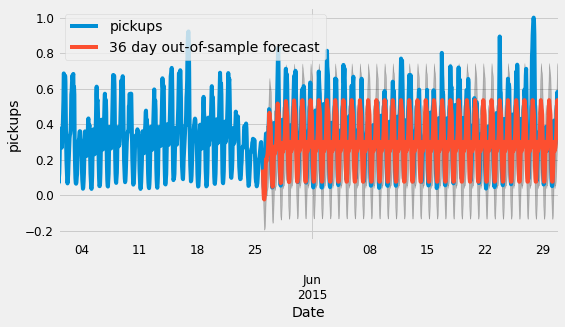

The Mean Squared Error of our prediction is 0.01
The Root Mean Squared Error of our prediction is 0.12
--------------------------------------------------
For Queens


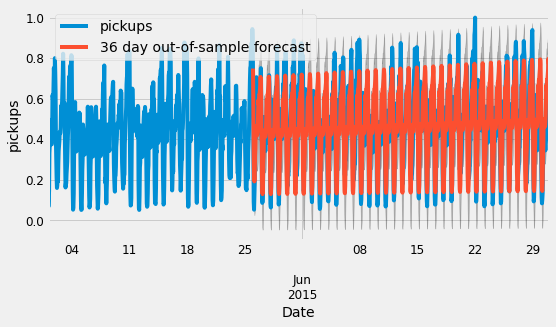

The Mean Squared Error of our prediction is 0.07
The Root Mean Squared Error of our prediction is 0.26
--------------------------------------------------
For Staten Island


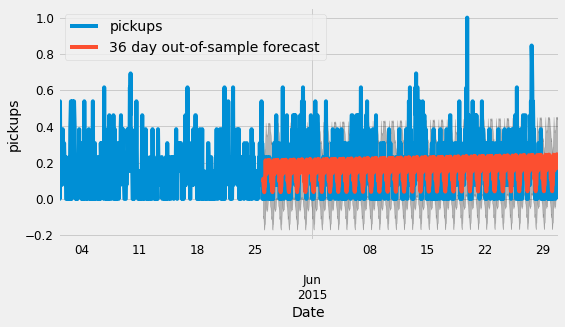

The Mean Squared Error of our prediction is 0.02
The Root Mean Squared Error of our prediction is 0.15
--------------------------------------------------
the average out-of-sample-forecast MSE across all boroughs: 0.032242403903933285
the average out-of-sample-forecast RMSE across all boroughs: 0.16454758631184732
the total time for forecasting is 5.024808883666992


In [64]:
fore_mse = []
fore_rmse=[]
start = t.time()
for df in result_dict.keys():
  print('For', df)
  mse, rmse = check_forecast(result_dict[df], data_dict[df])
  fore_mse.append(mse)
  fore_rmse.append(rmse)
  print(50*'-')

print('the average out-of-sample-forecast MSE across all boroughs:', np.mean(fore_mse))
print('the average out-of-sample-forecast RMSE across all boroughs:', np.mean(fore_rmse))

end = t.time()
print('the total time for forecasting is',  end-start)
times['forecast'] = end - start